In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
from math import sin, cos, radians, pi, sqrt, ceil, degrees
from time import sleep
%matplotlib widget
matplotlib.rcParams['animation.ffmpeg_path'] = "/Users/kiranmclernon/Documents/PhysicsCode/ffmpeg 2"


### Notes
- To run the ffmpeg executable needs to be in the source file

## Parametric Curve Animation

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
plt.title('Parametric Curve Plot')
ax.set_ylabel('Y-axis')
ax.set_xlabel('X-axis')
ax.set_zlabel('Z-axis')
ax.set_yticks((-10, 10, 1.0))
ax.set_zticks((-10,10,1.0))
# Prepare arrays x, y, z
#This sets up our domain (i.e. -6pi <= t<= 6pi
t = np.linspace(-6 * np.pi, 6 * np.pi, 100)

#Now we have to write our PARAMETERIC FUNCTIONS
x = t
y = t*np.sin(t)
z = t*np.cos(t)

camera = Camera(fig)
for i in range(len(x)):
    imx = x[i]
    imy = y[i]
    imz = z[i]
    ax.scatter(x[i-1], y[i-1], z[i-1],color='blue')
    ax.plot(x[0:i], y[0:i], z[0:i],color='red',linestyle='dotted')
    camera.snap()

    
anim = camera.animate()
writervideo = animation.FFMpegWriter(fps=24)
anim.save('curveplot.mp4', writer=writervideo)

# The Projectiles

### The Math

#### The Drag Math

$$D=\frac{C_dA\rho}{2}$$
$$F_d=Dv^2$$
$$a_x=\frac{-Dvv_x}{m}$$
$$a_y=-g-\frac{-Dvv_y}{m}$$

#### The Projectile Motion Math

$$v=u+at$$
$$s=ut+\frac{1}{2}at^2$$
$$s=vt$$

#### Pendulum Math
$$\frac{d^2\theta}{dt^2}-gL\sin(\theta)=0$$

### The Code

In [11]:
def lastElement(functionList): # Literally grab last element from list
    return functionList[len(functionList)-1]
def getElement(functionList, index): # grabs element from list if possible else returns the last element
    try:
        return functionList[index]
    except IndexError:
        return lastElement(functionList)
def getIndex(functionList,index): # returns input index except in the case that would be an index error then returns last element index
    try:
        placeholder = functionList[index]
        return index
    except IndexError:
        return len(functionList)-1
def getLastElements(array, length, index):
    if index < length-1:
        return array[:index+1]
    else:
        return array[index-length+1:index+1]
class projectilePath:
    '''
        class for storing paths 
        I want this to be inside of the motion sim class but idk how to do that
    '''
    def __init__(self, time, dt, ax, ay, vx, vy, sx,sy, initialConditions):
        self.dt = dt
        self.time=np.array(time)
        self.ax =np.array(ax)
        self.ay=np.array(ay)
        self.vx=np.array(vx)
        self.vy=np.array(vy)
        self.sx=np.array(sx)
        self.sy=np.array(sy)
        self.initialConditions = initialConditions
        self.maxTime=None
class MotionSim(): # a big class that I want to put more simulations - pendulum ??? in
    class ProjectileMotion:
        def __init__(self, launchAngle, initialVelocity, ballRadius, mass, dt, name, gravity=9.81):
            self.launchAngle = radians(launchAngle)
            self.initialVelocity = initialVelocity
            self.ballRadius = ballRadius
            self.mass=mass
            self.dt=dt
            self.name = name
            self.gravity = -abs(gravity)
        def projectileMotion(self):
            '''
                Projectle motion with SUVAT
                Total y displacement is always zero
            '''
            time = (-2 * self.initialVelocity*sin(self.launchAngle))/(-abs(self.gravity)) # calculate total time
            t = np.linspace(0, time,ceil(int(1/self.dt)*time)) # do calculations and shit
            sy = np.multiply(t,self.initialVelocity*sin(self.launchAngle)) + np.multiply((0.5*self.gravity),np.square(t))
            sx = self.initialVelocity*cos(self.launchAngle)*t
            vx  = np.ones(len(t))*self.initialVelocity*cos(self.launchAngle)
            vy = self.initialVelocity*sin(self.launchAngle) + self.gravity*t
            ax = np.zeros(len(t))
            ay = np.ones(len(t))*self.gravity
            return projectilePath(t,self.dt, ax,ay,vx,vy,sx,sy, self) #finished
        def projectileMotionAirResistance(self, fluidDensity = 1.1455):
            xVelocity = [self.initialVelocity*cos(self.launchAngle)] # i guess i should make variable names more consistent
            yVelocity = [self.initialVelocity*sin(self.launchAngle)]
            dragConstant = 0.47*(fluidDensity)*0.5*(pi*self.ballRadius**2) # the proportionality constant in the drag equation ie everything except v^2
            xDisplacement = [0] # lists!
            yDisplacement = [0]
            print(f"Drag Constant is : {dragConstant}") # just a cool thing to know i guess
            ax = [0]
            ay = [0]
            
            timeList = [0] 
            grounded = False
            while not grounded:
                if lastElement(timeList) > 0: # if we hit the ground already then break
                    if lastElement(yDisplacement) <=0:
                        break
                # the string below this was for debugging
                # print(f"xVelocity: {lastElement(xVelocity)}, yVelocity: {lastElement(yVelocity)} xDisplacement: {lastElement(xDisplacement)} yDisplacememt{lastElement(yDisplacement)}, time: {lastElement(timeList)}")
                timeList.append(lastElement(timeList)+self.dt) # add new time
                xDisplacement.append(lastElement(xDisplacement)+lastElement(xVelocity)*self.dt) # do s = s0 + vt
                yDisplacement.append(lastElement(yDisplacement)+lastElement(yVelocity)*self.dt)
                velocityMagnitude = sqrt(lastElement(xVelocity)**2+lastElement(yVelocity)**2) # this has to be known for drag 
                ax.append(-dragConstant*velocityMagnitude*lastElement(xVelocity)/self.mass) # calculate new x accleration with only force is drag
                ay.append(-abs(self.gravity)-(dragConstant*velocityMagnitude*lastElement(yVelocity)/self.mass)) # new y acceleration drag and gravity
                xVelocity.append(lastElement(xVelocity) + lastElement(ax)*self.dt) # update velocity with v= u +at
                yVelocity.append(lastElement(yVelocity) +  lastElement(ay)*self.dt) 
            return projectilePath(timeList, self.dt, ax,ay,xVelocity,yVelocity,xDisplacement,yDisplacement, self) # return the path when its done
        def velocityString(self, pathName:str, path:projectilePath, index:int): # a function to make the telemetery panel on the graph easier
            return f"\n{pathName}: \nvx: {round(getElement(path.vx,index),2)}\nvy: {round(getElement(path.vy,index),2)}\nv mag: {round(sqrt(getElement(path.vx,index)**2+getElement(path.vy,index)**2),2)}"
        def animate(self):
            airResistancePath = self.projectileMotionAirResistance() # get paths
            airFreePath = self.projectileMotion()
            if airResistancePath.time.max() >= airFreePath.time.max():
                airResistancePath.maxTime=True
                graphTime = airResistancePath.time # get the longest time it differs depending on the conditions
            else:
                airFreePath.maxTime=True
                graphTime = airFreePath.time
            fig = plt.figure() 
            gs = GridSpec(5, 10, figure=fig)
            ax1 = fig.add_subplot(gs[:, 0:7])
            ax2 = fig.add_subplot(gs[:, 7:])
            ax1.set_xlim(left=0,right= airFreePath.sx.max())
            ax1.set_ylim(bottom=0,top=airFreePath.sy.max())
            ax2.set_ylim(bottom=0,top=airFreePath.sy.max())
            ax2.set_frame_on(False)
            ax2.axes.get_yaxis().set_visible(False)
            ax2.axes.get_xaxis().set_visible(False)
            camera = Camera(fig)
            annotationStringConstant = f"initial conditions:\nsphere radius: {self.ballRadius} m\nsphere mass: {self.mass} kg\ninitial velocity: {self.initialVelocity} m/s\nlaunch angle: {degrees(self.launchAngle)} degrees"
            for i in range(len(graphTime)):
                ax1.scatter(airFreePath.sx[:getIndex(airFreePath.sx,i)],airFreePath.sy[:getIndex(airFreePath.sy,i)],color='red')
                ax1.scatter(airResistancePath.sx[:getIndex(airResistancePath.sx,i)],airResistancePath.sy[:getIndex(airResistancePath.sy,i)],color='blue') # plot the path
                vaccuumString = self.velocityString(pathName="vacuum projectile", path=airFreePath, index=i) # string for vaccum path
                airResistanceString = self.velocityString(pathName="air resistance projectile", path=airResistancePath, index=i) # string for air resistance path
                timestring = f"\ntime: {round(graphTime[i],3)}" # time!
                ax2.text(0,(airFreePath.sy.max()/3),s=(annotationStringConstant+timestring + vaccuumString+airResistanceString )) # update the text
                camera.snap() # snap
            anim = camera.animate()
            plt.close()
            writervideo = animation.FFMpegWriter(fps=round(len(graphTime)/graphTime.max())) # the frame rate is calculated so that the animation runs in real time
            anim.save("launchAngle/" + self.name+".mp4", writer=writervideo)      
    class Pendulum:
        def __init__(self, mass, radius, length, startingAngle, runTime,dt, simulationName, gravity=-9.81, fluidDensity = 1.455):
            assert(length>radius)
            self.mass=mass
            self.radius=radius
            self.runTime= runTime
            self.startingAngle = radians(startingAngle)
            self.dt=dt
            self.simulationName = simulationName
            self.length = length
            self.gravity = abs(gravity)
            self.fluidDensity = fluidDensity
        def createPath(self):
            print(f"starting angle = {degrees(self.startingAngle)}, in radians = {self.startingAngle}")
            print(f"-gravity/length = {-self.gravity/self.length}")
            time = [0]
            theta, thetadot, thetadoubledot = [self.startingAngle], [0], [(-self.gravity/self.length)*sin(self.startingAngle)]
            while lastElement(time) <= self.runTime:
                time.append(lastElement(time)+self.dt)
                thetadoubledot.append((-self.gravity/self.length)*sin(lastElement(theta)))
                thetadot.append(lastElement(thetadot)+lastElement(thetadoubledot)*self.dt)
                theta.append(lastElement(theta)+ lastElement(thetadot)*self.dt)
            return time, theta,thetadot,thetadoubledot
        def pathAirResistance(self):
            dragConstant = 0.47*(self.fluidDensity)*0.5*(pi*self.radius**2)
            time = [0]
            theta, thetadot, thetadoubledot = [self.startingAngle], [0], [(-self.gravity/self.length)*sin(self.startingAngle)]
            velocity = [0]
            while lastElement(time) <= self.runTime:
                velocity.append(lastElement(thetadot)*self.length)
                time.append(lastElement(time)+self.dt)
                drag = (-lastElement(velocity)*abs(lastElement(velocity))*dragConstant)/self.mass
                thetadoubledot.append((-self.gravity/self.length)*sin(lastElement(theta))+drag)
                thetadot.append(lastElement(thetadot)+lastElement(thetadoubledot)*self.dt)
                theta.append(lastElement(theta)+ lastElement(thetadot)*self.dt)
            return time, theta,thetadot,thetadoubledot, velocity
        def polarToRectangular(self, argument, magnitude):
            return (cos(argument)*magnitude, sin(argument)*magnitude)
        def animate(self):
            time,theta, dtheta, dtwotheta = self.createPath() # get path
            time = np.array(time) # numpy!
            length = np.ones(len(time))*self.length # pendulum rod
            theta = np.array(theta) - np.ones(len(theta))*(np.pi/2) # rotate around to real pendulum
            line = np.arange(round(100*self.length)+1)*0.01 # yhe
            fig = plt.figure()
            ax = fig.add_subplot(111,projection='polar')
            ax.set_frame_on(False)
            ax.axes.get_yaxis().set_visible(False)
            ax.axes.get_xaxis().set_visible(False)
            camera = Camera(fig)
            for i in range(len(time)):
                angleList = np.ones(round(100*self.length)+1)*theta[i]
                plt.plot(angleList, line, color='blue')
                ax.scatter(getLastElements(theta,10,i), getLastElements(length, 10,i), color= 'green')
                circle = plt.Circle(self.polarToRectangular(lastElement(theta), self.length), self.radius, transform=ax.transData._b, color="red", alpha=1)
                ax.add_artist(circle)
                camera.snap()
            anim = camera.animate()
            writervideo = animation.FFMpegWriter(fps=round(len(time)/time.max())) # the frame rate is calculated so that the animation runs in real time
            anim.save(self.simulationName + ".mp4", writer=writervideo)   


        


In [5]:
penispendulum = MotionSim.Pendulum(mass=2, radius=0.2,length=2, startingAngle=179, runTime=2, dt=0.01, simulationName='dead')

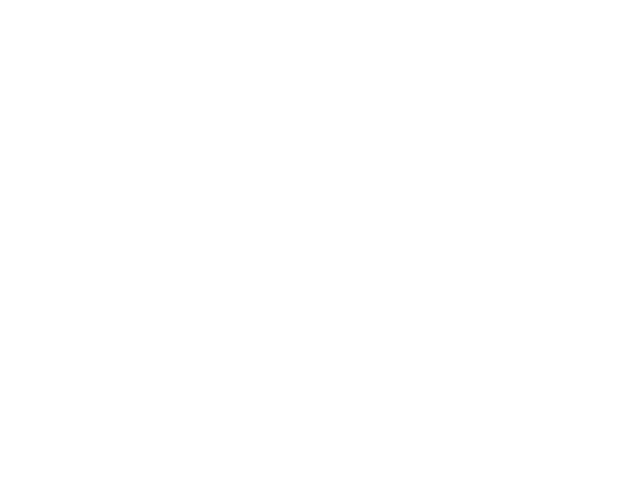

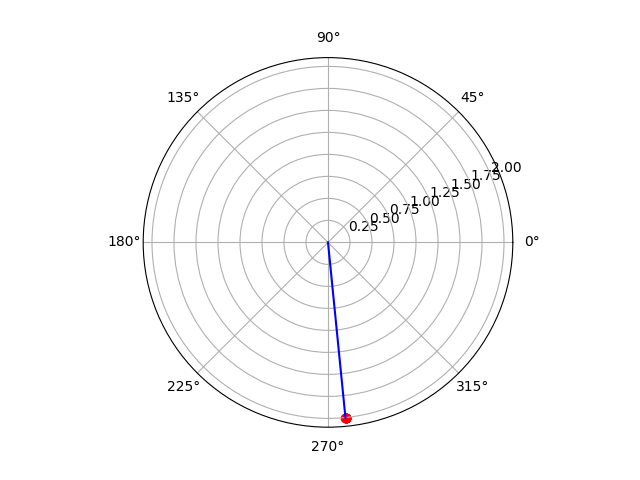

In [12]:
time,theta, dtheta, dtwotheta, velocity = penispendulum.pathAirResistance() # get path

time = np.array(time) # numpy!
length = np.ones(len(time))*2 # pendulum rod
theta = np.array(theta) - np.ones(len(theta))*(np.pi/2) # rotate around to real pendulum
line = np.arange(round(100*2)+1)*0.01 # yhe
dtheta = np.array(dtheta) - np.ones(len(dtheta))*(np.pi/2)
fig = plt.figure()
fig = plt.figure() 
ax1 = fig.add_subplot(111,projection='polar')

camera = Camera(fig)
for i in range(len(time)):
    angleList = np.ones(round(2*100)+1)*theta[i]
    plt.plot(angleList, line, color='blue')
    ax1.scatter(getLastElements(theta,10,i), getLastElements(length, 10,i), color= 'red')
    camera.snap()
anim = camera.animate()
writervideo = animation.FFMpegWriter(fps=round(len(time)/time.max())) # the frame rate is calculated so that the animation runs in real time
anim.save('test' + ".mp4", writer=writervideo)   
 

starting angle = 179.0, in radians = 3.12413936106985
-gravity/length = -4.905


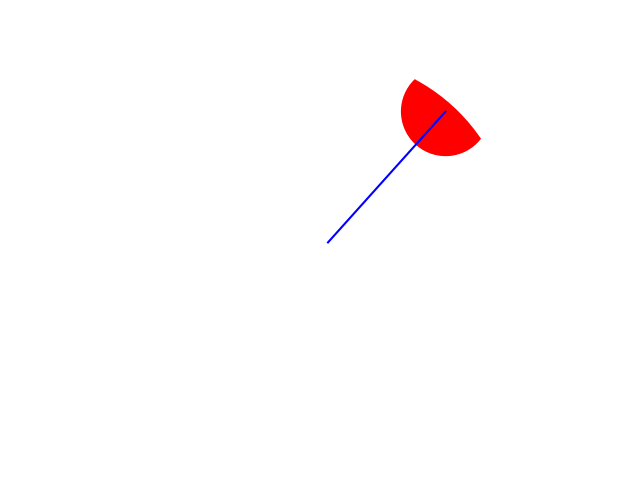

In [12]:
penispendulum = MotionSim.Pendulum(mass=2, radius=0.5,length=2, startingAngle=179, runTime=2, dt=0.01, simulationName='dead')
penispendulum.animate()

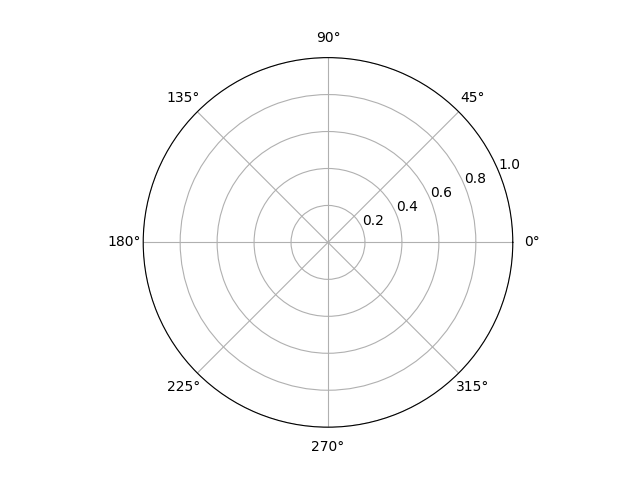

In [27]:
def polarToRectangular(argument, magnitude):
    return (cos(argument)*magnitude, sin(argument)*magnitude)
fig = plt.figure()
ax = fig.add_subplot(111,projection='polar')
camera = Camera(fig)
magnitude = np.ones(360)*10
angleList = np.deg2rad(np.arange(360))
ax.set_rmax(12)
for i in range(len(magnitude)):
    circle = plt.Circle(polarToRectangular(theta[i], magnitude = 10), 2, transform=ax.transData._b, color="red", alpha=1)
    ax.add_artist(circle)
    camera.snap()
anim = camera.animate()
writervideo = animation.FFMpegWriter(fps=24) # the frame rate is calculated so that the animation runs in real time
anim.save('test2' + ".mp4", writer=writervideo)   
 